### Loading libraries

In [124]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from IPython.display import display_html

from sklearn.model_selection import train_test_split, validation_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import scikitplot as skplt

from hyperopt import hp, STATUS_OK, Trials, fmin, tpe, partial

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

### Import datasets

In [2]:
train_data = pd.read_csv('data/titanic_train.csv')
test_data = pd.read_csv('data/titanic_test.csv')

In [3]:
train_data['IsCabin'] = train_data.Cabin.fillna(0)
train_data.loc[train_data.IsCabin != 0, 'IsCabin'] = 1
train_data.IsCabin = train_data.IsCabin.astype(int)

In [4]:
test_data['IsCabin'] = test_data.Cabin.fillna(0)
test_data.loc[test_data.IsCabin != 0, 'IsCabin'] = 1
test_data.IsCabin = test_data.IsCabin.astype(int)

In [5]:
train_data.shape

(891, 13)

In [6]:
test_data.shape

(418, 12)

In [7]:
data = train_data.drop(columns='Survived', axis=1).append(test_data).reset_index()

In [9]:
data.set_index('index', inplace=True)

In [12]:
data.shape

(1309, 12)

In [11]:
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,IsCabin
index,,,,,,,,,,,,
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


### Basic visualization of existing data

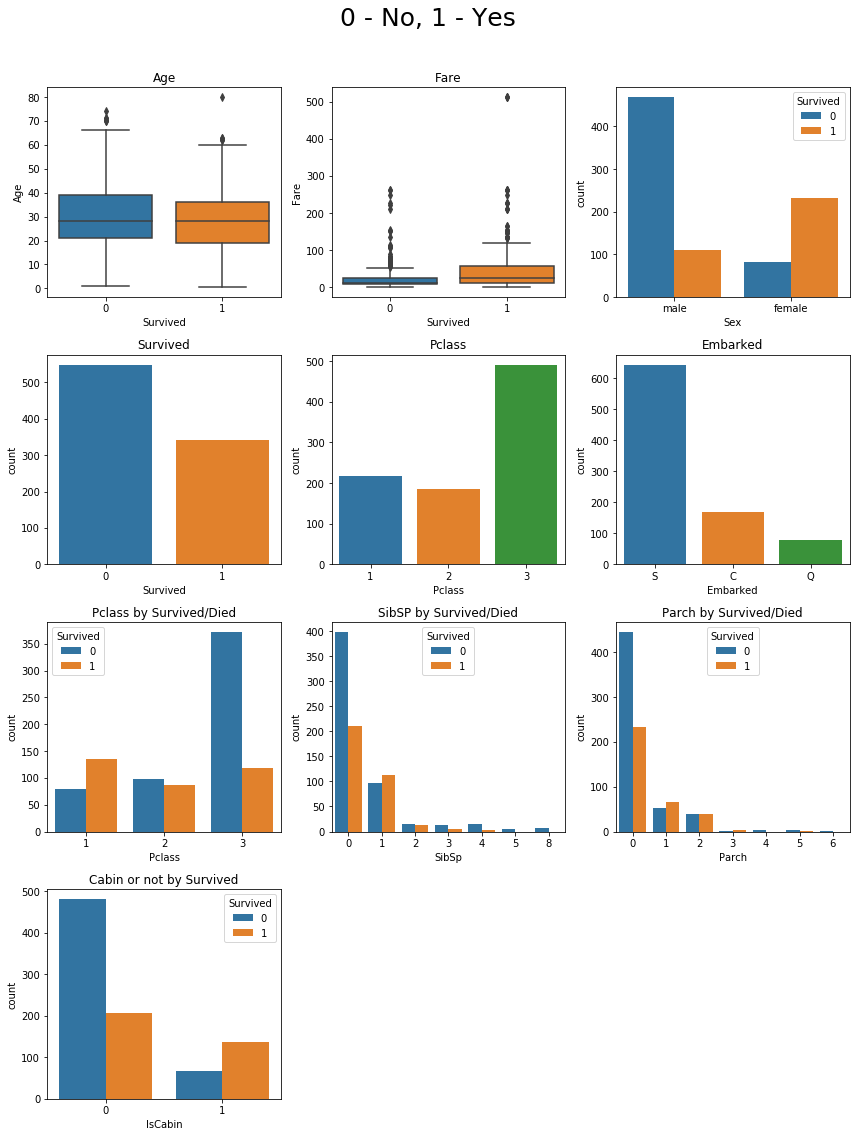

In [13]:
fig = plt.figure(figsize=(12, 15))
fig.suptitle("0 - No, 1 - Yes", fontsize=25, y=1.05)
plt.subplot2grid((4, 3), (0, 0))
sns.boxplot(x='Survived', y='Age', data=train_data, orient='v')
plt.title('Age')
plt.subplot2grid((4, 3), (0, 1))
sns.boxplot(x='Survived', y='Fare', data=train_data, orient='v')
plt.title('Fare')
plt.subplot2grid((4, 3), (0, 2))
sns.countplot(x='Sex', hue='Survived', data=train_data)
plt.subplot2grid((4, 3), (1, 0))
sns.countplot(x='Survived', data=train_data)
plt.title('Survived')
plt.subplot2grid((4, 3), (1, 1))
sns.countplot(x='Pclass', data=train_data)
plt.title('Pclass')
plt.subplot2grid((4, 3), (1, 2))
sns.countplot(x='Embarked', data=train_data)
plt.title('Embarked')
plt.subplot2grid((4, 3), (2, 0))
sns.countplot(x='Pclass', hue='Survived', data=train_data)
plt.title('Pclass by Survived/Died')
plt.subplot2grid((4, 3), (2, 1))
sns.countplot(x='SibSp', hue='Survived', data=train_data)
plt.title('SibSP by Survived/Died')
plt.subplot2grid((4, 3), (2, 2))
sns.countplot(x='Parch', hue='Survived', data=train_data)
plt.title('Parch by Survived/Died')
plt.subplot2grid((4, 3), (3, 0))
sns.countplot(x='IsCabin', hue='Survived', data=train_data)
plt.title('Cabin or not by Survived')

plt.tight_layout()

## Preprocessing data - version 2

In [29]:
data_v2 = data.copy()

In [30]:
data_v2.reset_index(inplace=True, drop=True)

In [31]:
data_v2.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,IsCabin
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [46]:
data_v2.describe()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,IsCabin
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,655.000000,2.294882,0.644003,29.881138,0.498854,0.385027,33.281071,1.394194,0.225363
std,378.020061,0.837836,0.478997,12.883193,1.041658,0.865560,51.741505,0.653499,0.417981
min,1.000000,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,328.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.895800,1.000000,0.000000
50%,655.000000,3.000000,1.000000,29.881138,0.000000,0.000000,14.454200,1.000000,0.000000
75%,982.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.275000,2.000000,0.000000
max,1309.000000,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,3.000000,1.000000


In [47]:
data_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Pclass       1309 non-null   int64  
 2   Name         1309 non-null   object 
 3   Sex          1309 non-null   int64  
 4   Age          1309 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1309 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1309 non-null   int64  
 11  IsCabin      1309 non-null   int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 122.8+ KB


### Handling missing values

In [32]:
data_v2.isna().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
IsCabin           0
dtype: int64

#### Mean Fare by Embarked for missing values

In [33]:
data_v2.loc[:][data_v2.Fare.isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,IsCabin
1043,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,0


In [34]:
data_v2.Embarked.value_counts(dropna=False)

S      914
C      270
Q      123
NaN      2
Name: Embarked, dtype: int64

In [35]:
data_v2.Fare = data_v2.Fare.fillna(data_v2.Fare[(data_v2.Embarked == 'S') & (data_v2.Pclass == 3)].mean())

In [36]:
data_v2.Age = data_v2.Age.fillna(data_v2.Age.mean())

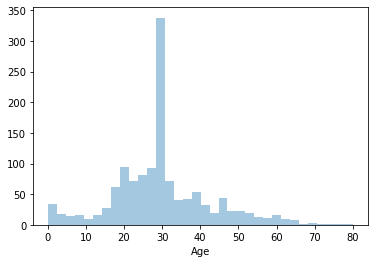

In [37]:
sns.distplot(data_v2.Age, kde=False);

#### Most common Embarked value for missing data

In [38]:
data_v2.Embarked.value_counts().idxmax()

'S'

In [39]:
data_v2.Embarked = data_v2.Embarked.fillna(data_v2.Embarked.value_counts().idxmax())

#### Mapping values for Embarked:
S -> 1  
C -> 2  
Q -> 3  

In [40]:
data_v2.Embarked = data_v2.Embarked.map({'S': 1, 'C': 2, 'Q': 3})

In [43]:
data_v2.Sex = data_v2.Sex.replace('female', 0)
data_v2.Sex = data_v2.Sex.replace('male', 1)
data_v2.Sex.astype(int)

0       1
1       0
2       0
3       0
4       1
       ..
1304    1
1305    0
1306    1
1307    1
1308    1
Name: Sex, Length: 1309, dtype: int64

#### Creating Fare Per Passenger Attribute

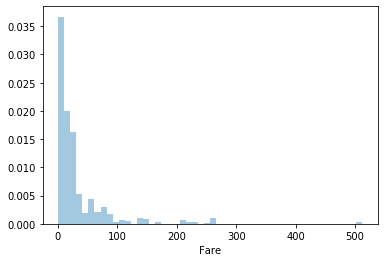

In [25]:
sns.distplot(data_v2.Fare, kde=False, norm_hist=True);

In [58]:
ticket_counts = data_v2.Ticket.value_counts()
tickets_index = ticket_counts.index

In [54]:
tempor_tickets = pd.Series(ticket_counts, index=tickets_index)
tempor_fares = pd.Series(data_v2.groupby('Ticket')['Fare'].mean(), index=tickets_index)

In [55]:
fare_pp = pd.DataFrame({'Count': ticket_counts,
                           'Fare': tempor_fares}, index=tickets_index)

In [56]:
fare_pp['FarePerPassenger'] = fare_pp.apply(lambda x: x.Fare/x.Count, axis=1)
fare_pp.index = fare_pp.index.rename('Ticket')

In [57]:
fare_pp.head()

,Count,Fare,FarePerPassenger
Ticket,,,
CA. 2343,11,69.5500,6.322727
CA 2144,8,46.9000,5.862500
1601,8,56.4958,7.061975
347077,7,31.3875,4.483929
347082,7,31.2750,4.467857


In [59]:
data_v2 = data_v2.join(fare_pp.loc[:,['FarePerPassenger']], on='Ticket')
data_v2.reset_index(inplace=True)

In [60]:
data_v2.head()

,index,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,IsCabin,FarePerPassenger
0,0,1,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,1,0,7.25000
1,1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,2,1,35.64165
2,2,3,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,0,7.92500
3,3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,1,1,26.55000
4,4,5,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,1,0,8.05000


## Pre-processing data - version 1

#### Preparing datasets to making predictions

In [62]:
survived_train = train_data.Survived
data_v1 = train_data.drop('Survived', axis=1).append(test_data, sort=False)

In [63]:
data_v1.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,IsCabin
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [64]:
data_v1.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,IsCabin
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,1309.000000
mean,655.000000,2.294882,29.881138,0.498854,0.385027,33.295479,0.225363
std,378.020061,0.837836,14.413493,1.041658,0.865560,51.758668,0.417981
min,1.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,2.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,655.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,982.000000,3.000000,39.000000,1.000000,0.000000,31.275000,0.000000
max,1309.000000,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000


#### Mark cabins by its type and missing values by "noCabin"

In [65]:
data_v1.Cabin = data.Cabin.str[0]
data_v1.Cabin = data.Cabin.fillna('noCabin')

#### Changing values of sex variable to 0 (female) and 1 (male)

In [66]:
data_v1.Sex = data_v1.Sex.replace('female', 0)
data_v1.Sex = data_v1.Sex.replace('male', 1)
data_v1.Sex= data_v1.Sex.astype(int)

#### How big a family a passenger has and what is the distribution of this variable?

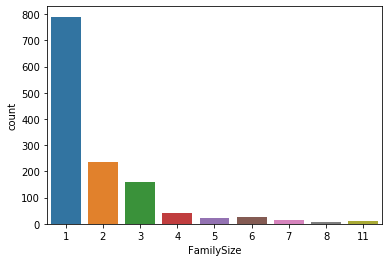

In [67]:
data_v1['FamilySize'] = data_v1.SibSp + data_v1.Parch + 1
data_v1['IsSolo'] = 0
data_v1.loc[data_v1.FamilySize == 1, 'IsSolo'] = 1
data_v1['SmallGroup'] = 0
data_v1.loc[data_v1.FamilySize.isin([2, 3, 4]), 'SmallGroup'] = 1
sns.countplot(data_v1['FamilySize']);

#### Extracting titles of passengers and presenting distribution of age by title

In [68]:
data_v1['Title'] = data_v1['Name'].str.replace('(.*, )|(\. .*)', '')
data_v1.Title = data_v1.Title.replace(['Mme', 'Ms', 'Lady', 'Mlle', 'the Countess', 'Dona'], 'lady')
data_v1.Title = data_v1.Title.replace(['Don', 'Major', 'Sir', 'Col', 'Capt', 'Jonkheer'], 'other')

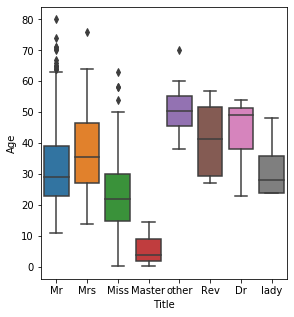

In [69]:
plt.figure(figsize=(15, 5))
plt.subplot2grid((1, 3), (0, 0))
sns.boxplot(x='Title', y='Age', data=data_v1);

#### If the age is unknown, the passenger receives the average age from the title category to which he belongs

In [70]:
for title in data_v1.Title.unique().tolist():
    data_v1.loc[data_v1.Title == title, ['Age']] = data_v1.loc[data_v1.Title == title, ['Age']].fillna(data_v1.loc[data_v1.Title == title, ['Age']].mean())

#### Calculating fare per passenger and presenting its distribution in the dataset (median for missing values)

In [71]:
tickets = set(data_v1.Ticket)
ticket_numbers = []
fares = []

for ticket in tickets:
    ticket_numbers.append(len(data_v1[data_v1.Ticket == ticket]))
    fares.append(data_v1['Fare'][data_v1.Ticket == ticket].mean())

tickets_sum = pd.DataFrame()
tickets_sum['Ticket'] = list(tickets)
tickets_sum['Count'] = ticket_numbers
tickets_sum['Fare'] = fares
tickets_sum['FarePP'] = tickets_sum['Fare']/tickets_sum['Count']
tickets_sum = tickets_sum.drop(['Count', 'Fare'], axis=1)

data_v1 = pd.merge(data_v1, tickets_sum, 'left', 'Ticket')

In [72]:
data_v1.FarePP = data_v1.FarePP.fillna(data_v1.FarePP.median())

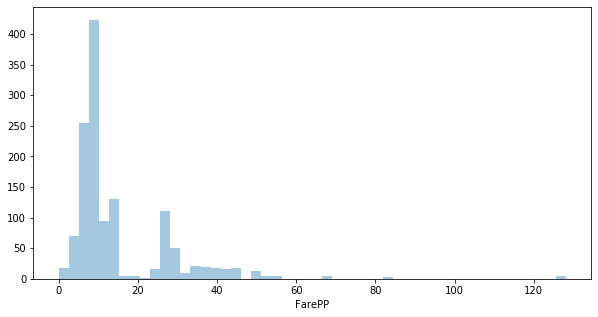

In [73]:
plt.figure(figsize=(10, 5))
sns.distplot(a=data_v1.FarePP, kde=False);

In [74]:
data_v1.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,IsCabin,FamilySize,IsSolo,SmallGroup,Title,FarePP
0,1,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,noCabin,S,0,2,0,1,Mr,7.25000
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,1,2,0,1,Mrs,35.64165
2,3,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,noCabin,S,0,1,1,0,Miss,7.92500
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,1,2,0,1,Mrs,26.55000
4,5,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,noCabin,S,0,1,1,0,Mr,8.05000


## Feature selection

In [77]:
orig_feats = ['PassengerId', 'SibSp', 'Parch', 'FarePP', 'FamilySize']
dummy_feats = ['Sex', 'Pclass', 'IsSolo', 'SmallGroup', 'Title']

data_v2_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'IsCabin']

In [78]:
orig_df = data_v1.loc[:, orig_feats]
dummy_df = pd.get_dummies(data_v1.loc[:, dummy_feats])

### Setting features and data

In [134]:
# df = data_v2.loc[:, data_v2_features]
df = pd.concat([orig_df, dummy_df], axis=1)

In [135]:
df.loc[890:,]

,PassengerId,SibSp,Parch,FarePP,FamilySize,Sex,Pclass,IsSolo,SmallGroup,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Title_lady,Title_other
890,891,0,0,7.750000,1,1,3,1,0,0,0,0,1,0,0,0,0
891,892,0,0,7.829200,1,1,3,1,0,0,0,0,1,0,0,0,0
892,893,1,0,7.000000,2,0,3,0,1,0,0,0,0,1,0,0,0
893,894,0,0,9.687500,1,1,2,1,0,0,0,0,1,0,0,0,0
894,895,0,0,8.662500,1,1,3,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,0,0,8.050000,1,1,3,1,0,0,0,0,1,0,0,0,0
1305,1306,0,0,36.300000,1,0,1,1,0,0,0,0,0,0,0,1,0
1306,1307,0,0,7.250000,1,1,3,1,0,0,0,0,1,0,0,0,0
1307,1308,0,0,8.050000,1,1,3,1,0,0,0,0,1,0,0,0,0


#### Splitting dataset to train, validation and submission subsets

In [136]:
X = df.loc[:890,]
y = survived_train
test_x = df.loc[891:, ]

In [137]:
train_x, val_x, train_y, val_y = train_test_split(X, y, random_state=0)

## Modeling

#### Auxiliary functions

In [138]:
def get_measures(y, pred_y):
    score_test = roc_auc_score(y, pred_y)
    gini_index = 2*score_test-1
    
    df = pd.DataFrame({'AUC': [round(score_test, 4)], 'Gini': [round(gini_index, 4)]})
    return df

def calculating_metrics(model, test_x, val_x, test_y, val_y):
    test = get_measures(test_y, model.predict_proba(test_x)[:, 1])
    val = get_measures(val_y, model.predict_proba(val_x)[:, 1])
    
    return pd.concat([test, val]).set_index([pd.Index(['TRAIN', 'VAL'])])

def get_performance_measure(y, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y[i]==y_pred[i] and y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y[i]!=y_pred[i]:
           FP += 1
        if y[i]==y_pred[i] and y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y[i]!=y_pred[i]:
           FN += 1
    return(TP, FP, TN, FN)

def print_indicators(real_y, predict_y):
    TP, FP, TN, FN = get_performance_measure(real_y, predict_y)
    

    pos = TP + FN
    neg = TN + FP

    tpr = TP / (TP + FN)
    tnr = TN / (TN + FP)
    fpr = FP / (FP + TN)
    fnr = FN / (FN + TP)

    acc = (TP + TN) / (TP + TN + FP + FN)

    msg = (f'Number of positive observations:\t\t{pos}\n'
           f'Number of negative observations:\t\t{neg}\n'
           f'Total number of observations:\t\t\t{pos+neg}\n\n'
           f'TPR (True Positive Rate), SE (sensitivity):\t{tpr:.4f}\n'
           f'TNR (True Negative Rate), SPC (specificity):\t{tnr:.4f}\n'
           f'FPR (False Positive Rate):\t\t\t{fpr:.4f}\n'
           f'FNR (False Negative Rate):\t\t\t{fnr:.4f}\n'
           f'ACC (Total Accuracy):\t\t\t\t{acc:.4f}'
          )
    return msg

### Decision Tree

In [139]:
model_DTC = DecisionTreeClassifier(random_state=1)

#### Finding the best parameters for Decision Tree model using Grid Search

In [140]:
grid_random_param = {
    'max_depth': np.linspace(1, 15, 15),
    'min_samples_split': np.linspace(0.01, 1, 10),
    'min_samples_leaf': np.linspace(0.01, 0.5, 5),
    'max_features': list(range(1, train_x.shape[1])),  
}

In [141]:
grid = GridSearchCV(model_DTC, grid_random_param, scoring='roc_auc')
grid.fit(train_x, train_y)
best_parameters_DTC_grid = grid.best_params_
print(best_parameters_DTC_grid)

{'max_depth': 5.0, 'max_features': 4, 'min_samples_leaf': 0.01, 'min_samples_split': 0.12}


#### Train model with the best-chosen parameters, predict values and get basic metrics

In [142]:
model_GS = DecisionTreeClassifier(**best_parameters_DTC_grid, random_state=1)
model_GS.fit(train_x, train_y)
cm_DTC_GS = calculating_metrics(model_GS, train_x, val_x, train_y, val_y)
cm_DTC_GS

,AUC,Gini
TRAIN,0.8753,0.7506
VAL,0.8459,0.6918


#### Confusion matrix

In [143]:
c_matrix_dtc_gs = confusion_matrix(val_y, model_GS.predict(val_x))
print(c_matrix_dtc_gs)

[[115  24]
 [ 20  64]]


#### Measures based on a confusion matrix

In [144]:
real_y = val_y.to_numpy(dtype=int)
predict_y = model_GS.predict(val_x)

In [145]:
print(f'\nTN:\t{c_matrix_dtc_gs[0][0]}\nFN:\t{c_matrix_dtc_gs[1][0]}\nTP:\t{c_matrix_dtc_gs[1][1]}\nFP:\t{c_matrix_dtc_gs[0][1]}\n')
print(print_indicators(real_y, predict_y))


TN:	115
FN:	20
TP:	64
FP:	24

Number of positive observations:		84
Number of negative observations:		139
Total number of observations:			223

TPR (True Positive Rate), SE (sensitivity):	0.7619
TNR (True Negative Rate), SPC (specificity):	0.8273
FPR (False Positive Rate):			0.1727
FNR (False Negative Rate):			0.2381
ACC (Total Accuracy):				0.8027


#### AUC chart

In [146]:
pred_prob = model_GS.predict_proba(val_x)
fpr_dtc_gs, tpr_dtc_gs, th = roc_curve(val_y, pred_prob[:, 1])
auc_dts_gs = roc_auc_score(val_y, pred_prob[:, 1])

AUC: 0.8459


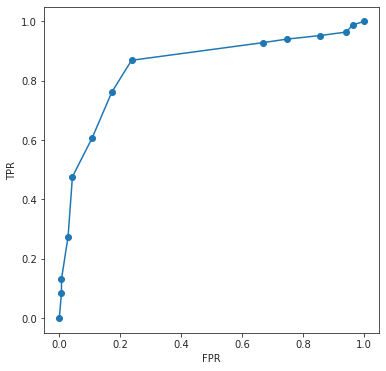

In [147]:
plt.figure(figsize=(6, 6))
plt.plot(fpr_dtc_gs, tpr_dtc_gs, 'o-')
plt.ylabel('TPR')
plt.xlabel('FPR')
print(f'AUC: {auc_dts_gs:.4f}')

#### LIFT chart

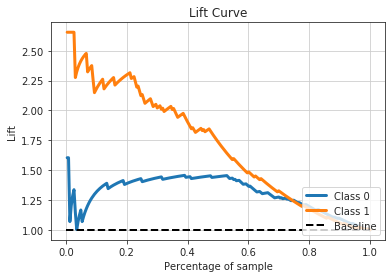

In [148]:
skplt.metrics.plot_lift_curve(val_y, pred_prob);

#### Finding the best parameters for Decision Tree model using Random Search

In [149]:
random_search = RandomizedSearchCV(model_DTC, grid_random_param, n_iter=200, scoring='roc_auc')
random_search.fit(train_x, train_y)
best_parameters_DTC_random = random_search.best_params_
print(best_parameters_DTC_random)

{'min_samples_split': 0.34, 'min_samples_leaf': 0.01, 'max_features': 15, 'max_depth': 10.0}


#### Train model with the best-chosen parameters, predict values and get basic metrics

In [150]:
model_RS = DecisionTreeClassifier(**best_parameters_DTC_random, random_state=1)
model_RS.fit(train_x, train_y)
cm_DTC_RS = calculating_metrics(model_RS, train_x, val_x, train_y, val_y)
cm_DTC_RS

,AUC,Gini
TRAIN,0.8601,0.7202
VAL,0.8334,0.6668


#### Finding the best parameters for Decision Tree model using Baysian optimalization

In [151]:
n_startup_jobs = 80
max_evals = 500
BS_results = []

In [152]:
b_opt_space = {
    'max_depth': hp.quniform('max_depth', 1, 15, 1),
    'min_samples_split': hp.uniform('min_samples_split', 0.01, 1),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.01, 0.5),
    'max_features': hp.quniform('max_features', 1, train_x.shape[1], 1)
}

In [153]:
def objective(space):
    b_params = {
        'max_depth': int(space['max_depth']),
        'min_samples_split': space['min_samples_split'],
        'min_samples_leaf': space['min_samples_leaf'],
        'max_features': int(space['max_features'])
    }
    model = DecisionTreeClassifier(**b_params, random_state=0)
    model.fit(train_x, train_y)
    pred_y = model.predict(val_x)
    
    score = -roc_auc_score(val_y, pred_y)
    return {'loss': score, 'status': STATUS_OK}

In [154]:
trials = Trials()
best_parameters_DTC_bayesian = fmin(fn=objective,
                   space=b_opt_space, 
                   algo=partial(tpe.suggest, n_startup_jobs=n_startup_jobs),
                   max_evals=max_evals,
                   trials=trials
                  )
print(f'best params: {best_parameters_DTC_bayesian}')

100%|██████████| 500/500 [00:21<00:00, 23.74trial/s, best loss: -0.8377869133264817]
best params: {'max_depth': 6.0, 'max_features': 13.0, 'min_samples_leaf': 0.01054469188441357, 'min_samples_split': 0.04146744612437586}


In [155]:
best_parameters_DTC_bayesian['max_features'] = int(best_parameters_DTC_bayesian['max_features'])

#### Train model with the best-chosen parameters, predict values and get basic metrics

In [156]:
model_BO = DecisionTreeClassifier(**best_parameters_DTC_bayesian, random_state=1)
model_BO.fit(train_x, train_y)
cm_DTC_BO = calculating_metrics(model_BO, train_x, val_x, train_y, val_y)
cm_DTC_BO

,AUC,Gini
TRAIN,0.9045,0.8090
VAL,0.8424,0.6848


#### Comparison of prediction results with using Decision Tree model

In [157]:
results_DTC = pd.concat([cm_DTC_GS, cm_DTC_RS, cm_DTC_BO],
                        axis=1,
                        keys={'GidSearchCV': cm_DTC_GS,
                              'RandomSearchCV': cm_DTC_RS,
                              'Bayesian Optimization': cm_DTC_BO}
                       )
results_DTC

GidSearchCV         RandomSearchCV         Bayesian Optimization        
              AUC    Gini            AUC    Gini                   AUC    Gini
TRAIN      0.8753  0.7506         0.8601  0.7202                0.9045  0.8090
VAL        0.8459  0.6918         0.8334  0.6668                0.8424  0.6848

### Random Forest

In [158]:
model_RFC = RandomForestClassifier(random_state=1)

#### Finding the best parameters for Random Forest model using Grid Search

In [159]:
grid_random_param_RFC = {
    'n_estimators': [200, 250, 300],
    'max_depth': [20, None],
    'min_samples_split': [5, 10, 12],
    'min_samples_leaf': [2, 3, 4, 5]
}

In [160]:
grid_RFC_GS = GridSearchCV(model_RFC, grid_random_param_RFC, scoring='roc_auc')
grid_RFC_GS.fit(train_x, train_y)
best_parameters_RFC_grid = grid_RFC_GS.best_params_
print(best_parameters_RFC_grid)

{'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 250}


#### Train model with the best-chosen parameters, predict values and get basic metrics

In [161]:
model_RFC_GS = RandomForestClassifier(**best_parameters_RFC_grid, random_state=1)
model_RFC_GS.fit(train_x, train_y)
cm_RFC_GS = calculating_metrics(model_RFC_GS, train_x, val_x, train_y, val_y)
cm_RFC_GS

,AUC,Gini
TRAIN,0.9445,0.8889
VAL,0.8845,0.7691


#### Finding the best parameters for Random Forest model using Random Search

In [162]:
random_RFC_RS = RandomizedSearchCV(model_RFC, grid_random_param_RFC, scoring='roc_auc')
random_RFC_RS.fit(train_x, train_y)
best_parameters_RFC_random = random_RFC_RS.best_params_
print(best_parameters_RFC_random)

{'n_estimators': 250, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_depth': 20}


#### Train model with the best-chosen parameters, predict values and get basic metrics

In [163]:
model_RFC_RS = RandomForestClassifier(**best_parameters_RFC_random, random_state=1)
model_RFC_RS.fit(train_x, train_y)
cm_RFC_RS = calculating_metrics(model_RFC_RS, train_x, val_x, train_y, val_y)
cm_RFC_RS

,AUC,Gini
TRAIN,0.9445,0.8889
VAL,0.8845,0.7691


#### Finding the best parameters for Random Forest model using Baysian optimalization

In [164]:
b_opt_space = {
    'n_estimators': hp.quniform('n_estimators', 200, 300, 50),
    'max_depth': hp.quniform('max_depth', 10, 30, 2),
    'min_samples_split': hp.quniform('min_samples_split', 4, 116, 2),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 8, 2)
}

In [165]:
def objective(space):
    b_opt_space = {
        'n_estimators': int(space['n_estimators']),
        'max_depth': int(space['max_depth']),
        'min_samples_split': int(space['min_samples_split']),
        'min_samples_leaf': int(space['min_samples_leaf']),
    }
    model = RandomForestClassifier(**b_opt_space, random_state=0)
    model.fit(train_x, train_y)
    pred_y = model.predict(val_x)
    score = -roc_auc_score(val_y, pred_y)
    return {'loss': score, 'status': STATUS_OK}

In [166]:
trials = Trials()
best_parameters_RFC_bayesian = fmin(fn=objective,
                                    space=b_opt_space,
                                    algo=partial(tpe.suggest, n_startup_jobs=n_startup_jobs),
                                    max_evals=max_evals,
                                    trials=trials
                                   )
print(f'best params: {best_parameters_RFC_bayesian}')

100%|██████████| 500/500 [04:02<00:00,  2.06trial/s, best loss: -0.8317060637204522]
best params: {'max_depth': 24.0, 'min_samples_leaf': 2.0, 'min_samples_split': 6.0, 'n_estimators': 250.0}


In [167]:
best_parameters_RFC_bayesian['n_estimators'] = int(best_parameters_RFC_bayesian['n_estimators'])
best_parameters_RFC_bayesian['max_depth'] = int(best_parameters_RFC_bayesian['max_depth'])
best_parameters_RFC_bayesian['min_samples_split'] = int(best_parameters_RFC_bayesian['min_samples_split'])
best_parameters_RFC_bayesian['min_samples_leaf'] = int(best_parameters_RFC_bayesian['min_samples_leaf'])

#### Train model with the best-chosen parameters, predict values and get basic metrics

In [168]:
model_RFC_BO = RandomForestClassifier(**best_parameters_RFC_bayesian, random_state=0)
model_RFC_BO.fit(train_x, train_y)
cm_RFC_BO = calculating_metrics(model_RFC_BO, train_x, val_x, train_y, val_y)
cm_RFC_BO

,AUC,Gini
TRAIN,0.9732,0.9463
VAL,0.8911,0.7821


#### Comparison of prediction results with using Random Forest model

In [169]:
results_RFC = pd.concat([cm_RFC_GS, cm_RFC_RS, cm_RFC_BO],
                        axis=1,
                        keys={'GidSearchCV': cm_RFC_GS,
                              'RandomSearchCV': cm_RFC_RS,
                              'Bayesian Optimization': cm_RFC_BO}
                       )
results_RFC

GidSearchCV         RandomSearchCV         Bayesian Optimization        
              AUC    Gini            AUC    Gini                   AUC    Gini
TRAIN      0.9445  0.8889         0.9445  0.8889                0.9732  0.9463
VAL        0.8845  0.7691         0.8845  0.7691                0.8911  0.7821

### KNN (K nearest neighbour)

In [170]:
scale = MinMaxScaler()

In [171]:
X_scaled = pd.DataFrame(scale.fit_transform(X), columns=X.columns)

In [172]:
test_x_scaled = pd.DataFrame(scale.fit_transform(test_x), columns=test_x.columns)
train_x_s, val_x_s, train_y_s, val_y_s = train_test_split(X_scaled, y, random_state=1)

In [173]:
for i in range(1, 20):
    knn_model = KNeighborsClassifier(n_neighbors=i).fit(train_x_s, train_y_s)
    print(knn_model.score(val_x_s, val_y_s))

0.7399103139013453
0.7130044843049327
0.7443946188340808
0.7488789237668162
0.757847533632287
0.757847533632287
0.7713004484304933
0.7713004484304933
0.7623318385650224
0.757847533632287
0.7802690582959642
0.7757847533632287
0.7802690582959642
0.7802690582959642
0.7623318385650224
0.7668161434977578
0.7713004484304933
0.7757847533632287
0.7892376681614349


In [174]:
calculating_metrics(KNeighborsClassifier(n_neighbors=11).fit(val_x_s, val_y_s), train_x_s, val_x_s, train_y_s, val_y_s)

,AUC,Gini
TRAIN,0.8205,0.6410
VAL,0.8624,0.7248


In [175]:
train_score, test_score = validation_curve(KNeighborsClassifier(),
                                           X,
                                           y,
                                           param_name='n_neighbors',
                                           param_range=range(1, 21),
                                           cv=5
                                          )

In [176]:
train_score_mean = np.mean(train_score, axis=1)
test_score_mean = np.mean(test_score, axis=1)

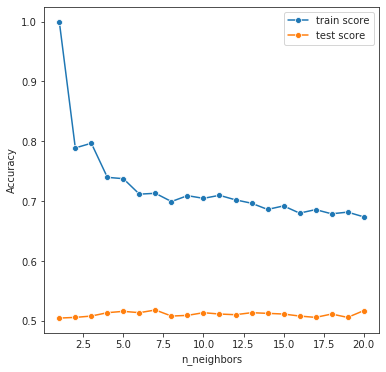

In [177]:
plt.figure(figsize=(6, 6))
sns.set_style('ticks')
sns.lineplot(x=range(1,21), y=train_score_mean, markers=True, marker='o', )
sns.lineplot(x=range(1,21), y=test_score_mean, markers=True, marker='o')
plt.legend(['train score', 'test score'])
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy');

## Submission

In [178]:
subm = pd.read_csv('data/gender_submission.csv')

In [179]:
pred_values = model_RFC_BO.predict(test_x)

In [180]:
subm_values = pd.Series(pred_values, name='Survived', index=range(len(pred_values)))

In [181]:
subm.Survived = subm_values

In [182]:
subm.to_csv('data/gender_submission.csv', index=False)